In [1]:
# !pip install tensorflow_datasets scikit-image sklearn cython

In [2]:
# # need to install pycocotools AFTER cython
# !pip install pycocotools

In [3]:
# !apt-get update && apt-get install -y git
# !rm -rf data/cocoapi
# !cd data && git clone https://github.com/cocodataset/cocoapi
# !cd data/cocoapi/PythonAPI && make -j $(nproc)

In [4]:
# !mkdir -p data

# !cd data && wget http://images.cocodataset.org/zips/train2017.zip
# !cd data && wget http://images.cocodataset.org/zips/val2017.zip
# !cd data && wget http://images.cocodataset.org/zips/test2017.zip
# !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

In [5]:
# %%time
# !cd data && unzip -q train2017.zip

In [6]:
# %%time
# !cd data && unzip -q val2017.zip

In [7]:
# %%time
# !cd data && unzip -q test2017.zip

In [8]:
# %%time
# !cd data && unzip -q annotations_trainval2017.zip

In [9]:
import tensorflow_datasets as tfds
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import skimage.io as io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, BatchNormalization, Average, Convolution2D, MaxPooling2D, Activation, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report
tf.__version__

'2.0.1'

In [10]:
COCO_ROOT = './data'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

In [11]:
if tf.__version__.startswith("1."):
    val_acc_name = "val_acc"
    acc_name = "acc"
else:
#     tf.compat.v1.disable_eager_execution()
    val_acc_name = "val_accuracy"
    acc_name = "accuracy"

In [12]:
BATCH_SIZE = 32
IMG_INP_SIZE = 192
# Эпохи большие, поэтому ввел переменную INTERMEDIATE_STEP, чтобы раз 
# в ОБЩЕЕ_КОЛИЧЕСТВО_ПРИМЕРОВ//BATCH_SIZE//INTERMEDIATE_STEP батчей была валидация и отметка в истории
INTERMEDIATE_STEP = 20
EPOCHS = 21

### Подготовка данных

In [13]:
class Dataset():
    
    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)
        
        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: #central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]
        
        return img
    
    def train_dataset(self, batch_size, epochs, inp_size):
        
        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)
            
            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class
        
        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
#         dataset = dataset.take(BATCH_SIZE*20) # FOR DEBUGGING
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(10)
        
        return dataset
    
    def val_dataset(self, batch_size, inp_size):
        
        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)
            
            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class
        
        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(10)
        
        return dataset

In [14]:
class COCO_Dataset(Dataset):
    
    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)
        
    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])
        
        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1,1,3))
        
        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)
        
        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)
        
        return img_combined

In [15]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=15.88s)
creating index...
index created!
loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [16]:
train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=EPOCHS, inp_size=IMG_INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=IMG_INP_SIZE)

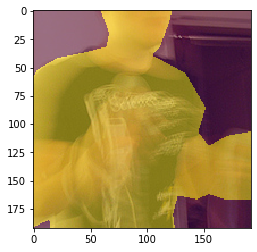

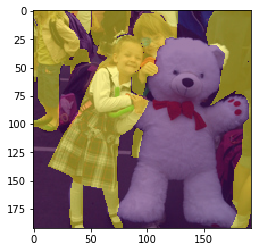

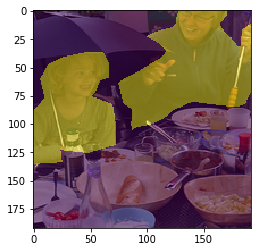

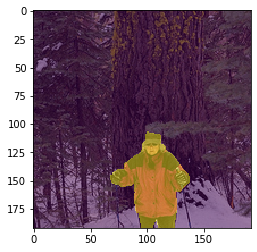

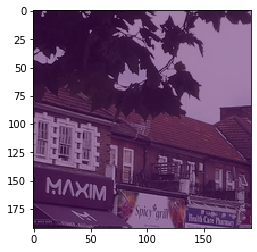

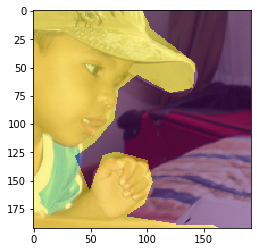

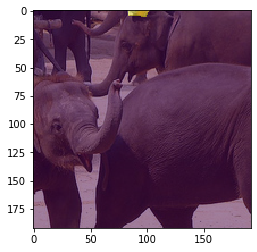

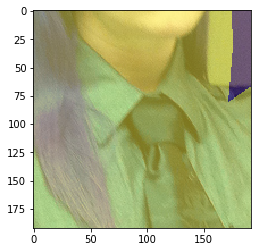

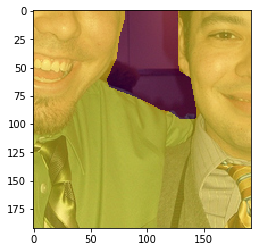

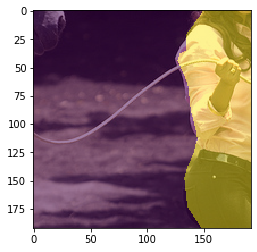

In [17]:
for idx in range(10):
    i = next(iter(val_ds))
    sample = i[0][idx].numpy()
    seg_map = plt.get_cmap('viridis')(i[1][idx].numpy().reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + seg_map*0.5)
    plt.show()

### Проектирование модели

In [18]:
def build_model():
    x = tf.keras.layers.Input((IMG_INP_SIZE, IMG_INP_SIZE, 3))
    
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2,2))(out1)
    
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2,2))(out2)
    
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2,2))(out3)
    
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2,2))(out4)
    
    out = tf.keras.layers.Conv2D(1024, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(512, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)
    
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(256, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)
    
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)
    
    out = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(out)
    
    out = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)
    
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3,3), padding='same', activation='sigmoid')(out)
    
    return tf.keras.Model(inputs=x, outputs=out)

In [19]:
try:
    del model
    K.clear_session()
except:
    pass
model = build_model()

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 96, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

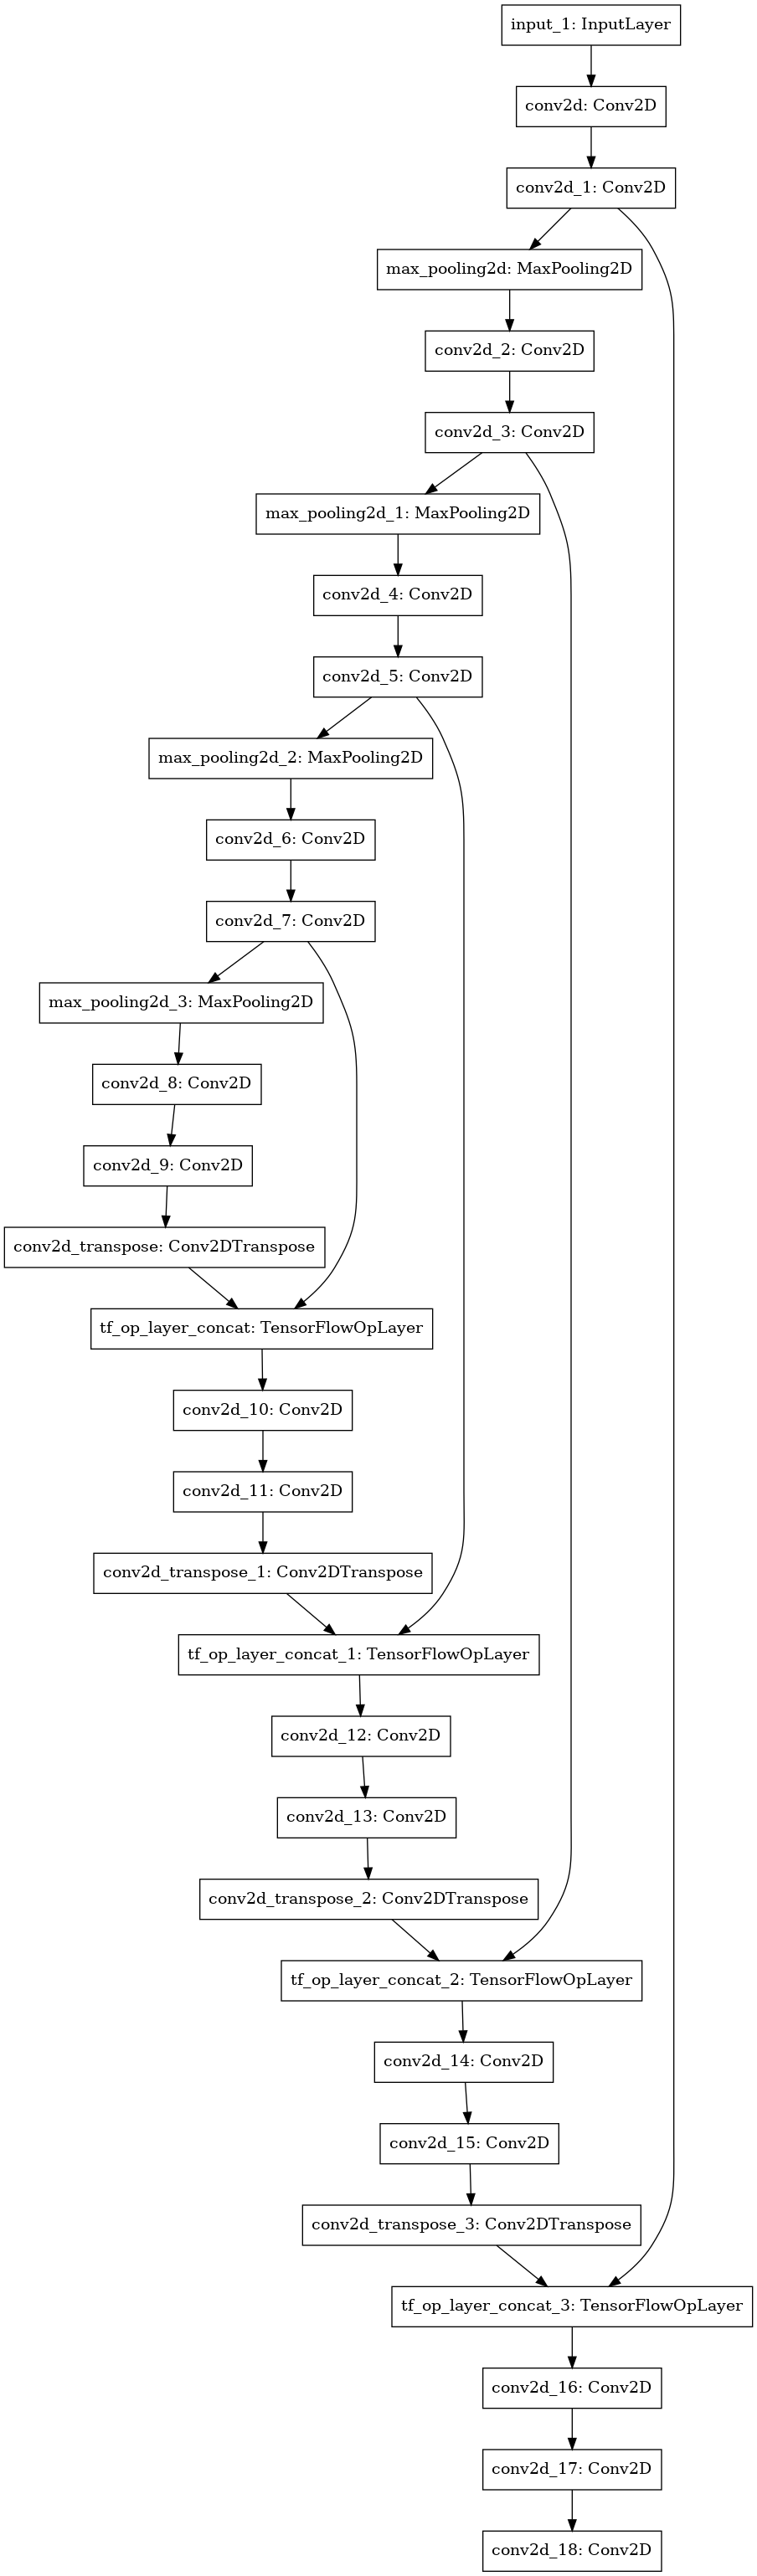

In [21]:
tf.keras.utils.plot_model(model)

### Тренировка модели

In [22]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer="adam", loss=loss)

In [23]:
checkpoint = ModelCheckpoint('dz_04_semanticheskaya_segmentatsiya.hdf5',
                            monitor="val_loss",
                            save_best_only=True,
                            period=1,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor="val_loss", 
                                        min_delta=1e-6, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss",
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [24]:
%%time
# Количество шагов в эпохе поделено на INTERMEDIATE_STEP чтобы валидация и отметки в истории были почаще, по факту 1 
# полная эпоха будет раз в INTERMEDIATE_STEP отмеченных эпох.
# Таким образом модель будет тренирована EPOCHS полных эпох, а отметок будет в INTERMEDIATE_STEP раз больше.
history = model.fit(train_ds, 
                 epochs=EPOCHS * INTERMEDIATE_STEP,
                 steps_per_epoch=len(COCO_dataset_train.img_list)//BATCH_SIZE//INTERMEDIATE_STEP, 
                 validation_data=val_ds, 
                 validation_steps=10,
                   callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback])

Train for 100 steps, validate for 10 steps
Epoch 1/420
 99/100 [============================>.] - ETA: 0s - loss: 0.5197
Epoch 00001: val_loss improved from inf to 0.55302, saving model to dz_04_semanticheskaya_segmentatsiya.hdf5
100/100 [==============================] - 95s 951ms/step - loss: 0.5195 - val_loss: 0.5530
Epoch 2/420
 99/100 [============================>.] - ETA: 0s - loss: 0.4806
Epoch 00002: val_loss improved from 0.55302 to 0.50945, saving model to dz_04_semanticheskaya_segmentatsiya.hdf5
100/100 [==============================] - 84s 844ms/step - loss: 0.4814 - val_loss: 0.5095
Epoch 3/420
 99/100 [============================>.] - ETA: 0s - loss: 0.4903
Epoch 00003: val_loss did not improve from 0.50945
100/100 [==============================] - 81s 807ms/step - loss: 0.4894 - val_loss: 0.5260
Epoch 4/420
 99/100 [============================>.] - ETA: 0s - loss: 0.4757
Epoch 00004: val_loss did not improve from 0.50945
100/100 [==============================] - 81

Epoch 35/420
 99/100 [============================>.] - ETA: 0s - loss: 0.3277
Epoch 00035: val_loss improved from 0.37272 to 0.36423, saving model to dz_04_semanticheskaya_segmentatsiya.hdf5
100/100 [==============================] - 86s 856ms/step - loss: 0.3280 - val_loss: 0.3642
Epoch 36/420
 99/100 [============================>.] - ETA: 0s - loss: 0.3216
Epoch 00036: val_loss did not improve from 0.36423
100/100 [==============================] - 82s 819ms/step - loss: 0.3213 - val_loss: 0.3764
Epoch 37/420
 99/100 [============================>.] - ETA: 0s - loss: 0.3281
Epoch 00037: val_loss did not improve from 0.36423
100/100 [==============================] - 82s 818ms/step - loss: 0.3282 - val_loss: 0.3657
Epoch 38/420
 99/100 [============================>.] - ETA: 0s - loss: 0.3240
Epoch 00038: val_loss did not improve from 0.36423
100/100 [==============================] - 82s 822ms/step - loss: 0.3235 - val_loss: 0.3962
Epoch 39/420
 99/100 [============================

Epoch 69/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2788
Epoch 00069: val_loss did not improve from 0.30001
100/100 [==============================] - 81s 814ms/step - loss: 0.2781 - val_loss: 0.3116
Epoch 70/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2660
Epoch 00070: val_loss did not improve from 0.30001
100/100 [==============================] - 82s 823ms/step - loss: 0.2668 - val_loss: 0.3120
Epoch 71/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2771
Epoch 00071: val_loss did not improve from 0.30001

Epoch 00071: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
100/100 [==============================] - 82s 821ms/step - loss: 0.2764 - val_loss: 0.3245
Epoch 72/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2744
Epoch 00072: val_loss did not improve from 0.30001
100/100 [==============================] - 82s 817ms/step - loss: 0.2743 - val_loss: 0.3063
Epoch 73/420
 99/100 [========

Epoch 104/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2689
Epoch 00104: val_loss improved from 0.29090 to 0.28925, saving model to dz_04_semanticheskaya_segmentatsiya.hdf5
100/100 [==============================] - 86s 857ms/step - loss: 0.2692 - val_loss: 0.2893
Epoch 105/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2659
Epoch 00105: val_loss did not improve from 0.28925
100/100 [==============================] - 82s 824ms/step - loss: 0.2658 - val_loss: 0.3002
Epoch 106/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2615
Epoch 00106: val_loss did not improve from 0.28925
100/100 [==============================] - 82s 819ms/step - loss: 0.2616 - val_loss: 0.3114
Epoch 107/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2579
Epoch 00107: val_loss did not improve from 0.28925
100/100 [==============================] - 81s 812ms/step - loss: 0.2583 - val_loss: 0.3262
Epoch 108/420
 99/100 [=======================

Epoch 138/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2646
Epoch 00138: val_loss did not improve from 0.28856
100/100 [==============================] - 81s 815ms/step - loss: 0.2645 - val_loss: 0.3252
Epoch 139/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2594
Epoch 00139: val_loss did not improve from 0.28856
100/100 [==============================] - 82s 819ms/step - loss: 0.2597 - val_loss: 0.3232
Epoch 140/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2648
Epoch 00140: val_loss did not improve from 0.28856
100/100 [==============================] - 82s 819ms/step - loss: 0.2649 - val_loss: 0.2927
Epoch 141/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2701
Epoch 00141: val_loss did not improve from 0.28856

Epoch 00141: ReduceLROnPlateau reducing learning rate to 1e-08.
100/100 [==============================] - 82s 817ms/step - loss: 0.2699 - val_loss: 0.3415
Epoch 142/420
 99/100 [====================

Epoch 174/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2640
Epoch 00174: val_loss did not improve from 0.28170
100/100 [==============================] - 82s 821ms/step - loss: 0.2644 - val_loss: 0.3049
Epoch 175/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2628
Epoch 00175: val_loss did not improve from 0.28170
100/100 [==============================] - 82s 821ms/step - loss: 0.2632 - val_loss: 0.2823
Epoch 176/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2710
Epoch 00176: val_loss did not improve from 0.28170
100/100 [==============================] - 82s 819ms/step - loss: 0.2708 - val_loss: 0.3030
Epoch 177/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2648
Epoch 00177: val_loss did not improve from 0.28170
100/100 [==============================] - 81s 812ms/step - loss: 0.2651 - val_loss: 0.3211
Epoch 178/420
 99/100 [============================>.] - ETA: 0s - loss: 0.2634
Epoch 00178: val_loss did no

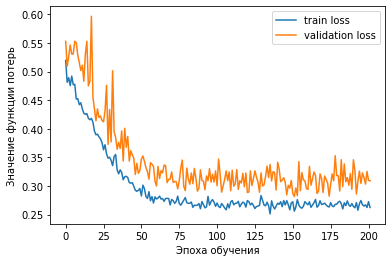

In [25]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()
plt.show()

### Предсказание с помощью модели

In [26]:
test_batch = next(iter(val_ds))

In [27]:
prediction = model.predict(test_batch)

In [28]:
prediction.shape

(32, 192, 192, 1)

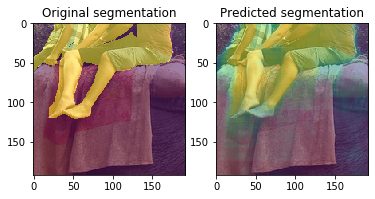

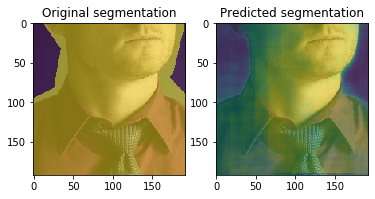

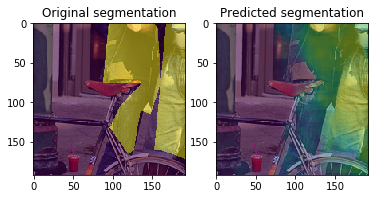

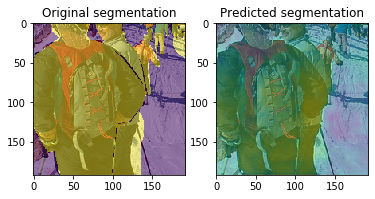

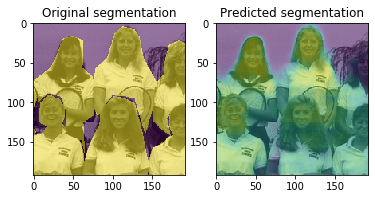

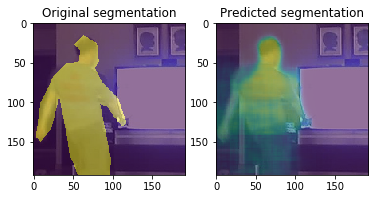

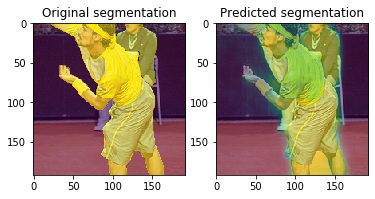

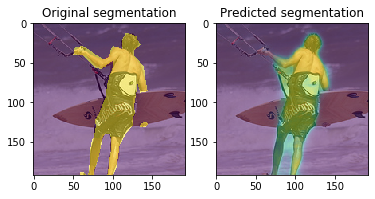

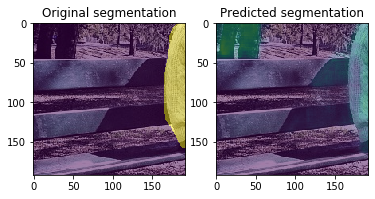

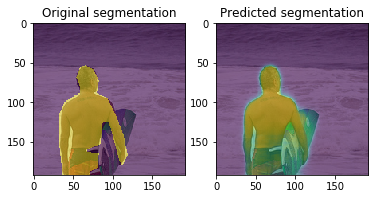

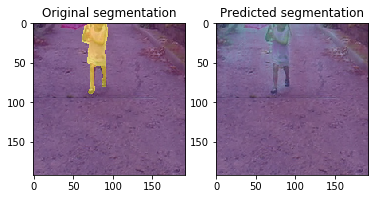

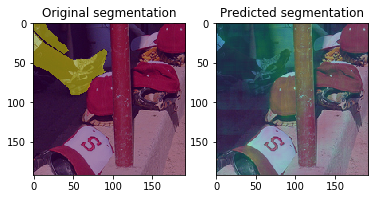

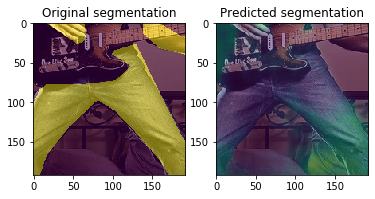

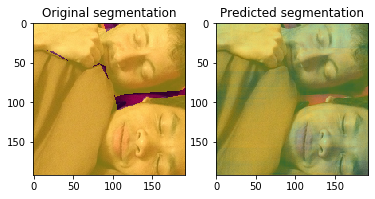

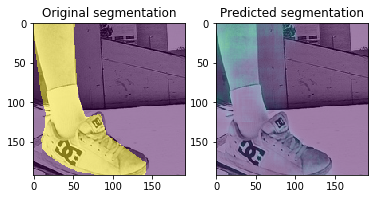

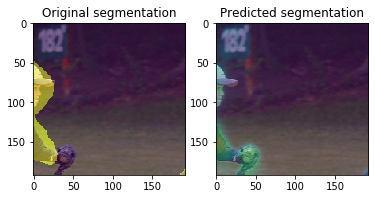

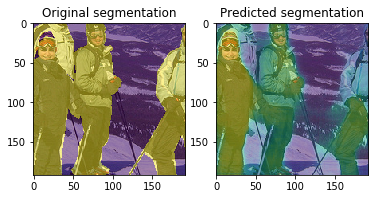

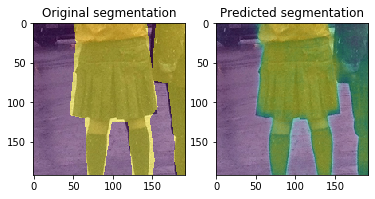

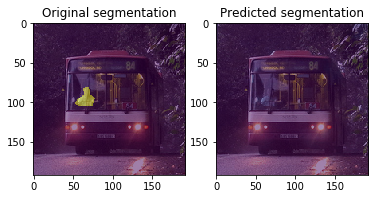

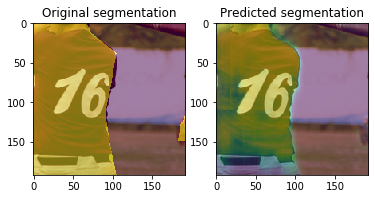

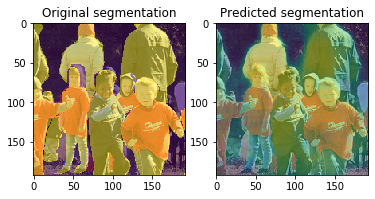

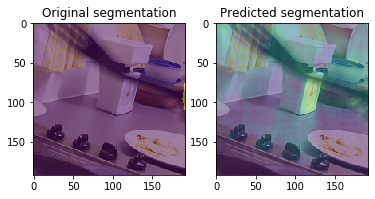

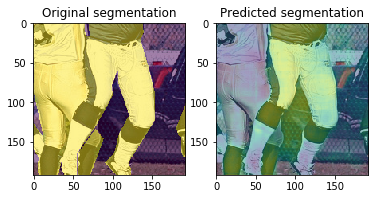

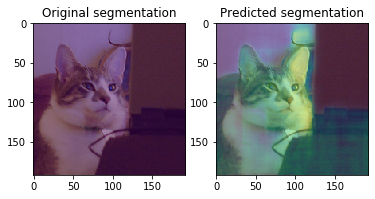

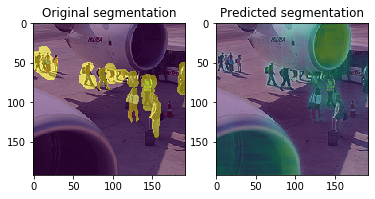

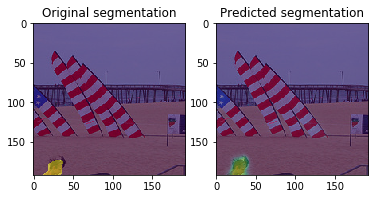

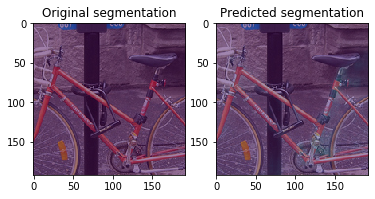

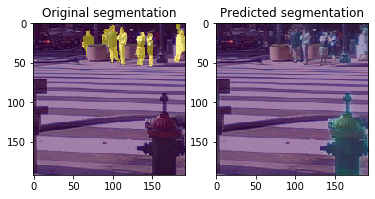

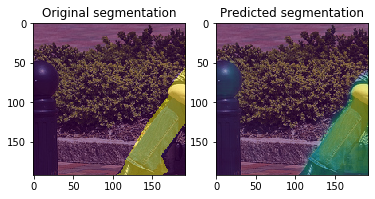

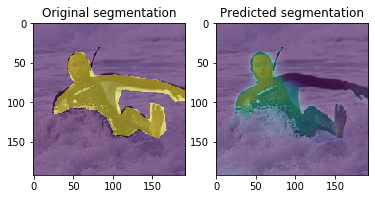

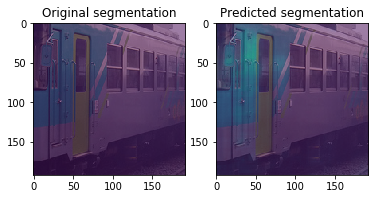

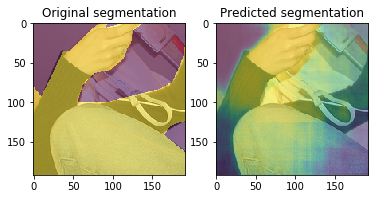

In [29]:
for idx in range(len(prediction)):
    sample = test_batch[0][idx].numpy()
    
    fig = plt.figure()
    
    plt.subplot(1,2,1)
    plt.title("Original segmentation")
    actual_seg_map = plt.get_cmap('viridis')(test_batch[1][idx].numpy().reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + actual_seg_map*0.5)
    
    plt.subplot(1,2,2)
    plt.title("Predicted segmentation")
    actual_seg_map = plt.get_cmap('viridis')(prediction[idx].reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + actual_seg_map*0.5)
    
    plt.show()

### Достаточно интересный результат достигнут, но конечно далекий от совершенства. Возможно требуется более сложная архитектура модели.